In [1]:
import numpyro
import jax
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import arviz as az
import scipy.stats as stats
import scipy

numpyro.set_host_device_count(4)

#https://operahollandpark.com/productions/das-lied-von-der-erde/https://operahollandpark.com/productions/das-lied-von-der-erde/https://operahollandpark.com/productions/das-lied-von-der-erde/https://operahollandpark.com/productions/das-lied-von-der-erde/https://operahollandpark.com/productions/das-lied-von-der-erde/# 12E1

ordered: age

unordered: nationality

## 12E2

numpyro.dist

In [2]:
df = pandas.read_csv('UCBadmit.csv', sep=';')

In [3]:
df

,dept,applicant.gender,admit,reject,applications
1,A,male,512,313,825
2,A,female,89,19,108
3,B,male,353,207,560
4,B,female,17,8,25
5,C,male,120,205,325
6,C,female,202,391,593
7,D,male,138,279,417
8,D,female,131,244,375
9,E,male,53,138,191
10,E,female,94,299,393


In [4]:
def model1(n, obs, gid):
    
    alpha = numpyro.sample(
        'alpha',
        numpyro.distributions.Normal(0, 1.5),
        sample_shape=(2,),
    )
    
    p = jax.numpy.exp(alpha[gid]) 
    
    numpyro.sample(
        'obs',
        numpyro.distributions.Binomial(total_count=n, probs=p),
        obs=obs,
    )

In [5]:
sampler = numpyro.infer.NUTS(model1)
mcmc = numpyro.infer.MCMC(sampler, num_warmup=1000, num_samples=1000, num_chains=4)
mcmc.run(jax.random.PRNGKey(0), n=df['applications'].to_numpy(), obs=df['admit'].to_numpy(), gid=(df['applicant.gender']=='male').astype(int).to_numpy())

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [6]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
  alpha[0]     -1.19      0.04     -1.19     -1.25     -1.14   3941.21      1.00
  alpha[1]     -0.81      0.02     -0.81     -0.84     -0.77   3250.09      1.00

Number of divergences: 0


In [17]:
df

,dept,applicant.gender,admit,reject,applications
0,A,male,512,313,825
1,A,female,89,19,108
2,B,male,353,207,560
3,B,female,17,8,25
4,C,male,120,205,325
5,C,female,202,391,593
6,D,male,138,279,417
7,D,female,131,244,375
8,E,male,53,138,191
9,E,female,94,299,393


In [8]:
import numpyro
import jax
import pandas

numpyro.set_host_device_count(4)

In [43]:
def model2(n, obs, gid):
    alpha = numpyro.sample(
        'alpha',
        numpyro.distributions.Normal(0, 1.5),
        sample_shape=(2,),
    )
    diff_alpha = numpyro.deterministic(
        'diff_alpha',
        alpha[0] - alpha[1],
    )
    phi = numpyro.sample(
        'phi',
        numpyro.distributions.Exponential(rate=1.),
    )
    theta = numpyro.deterministic('theta', phi+2)
    
    pbar = numpyro.deterministic('pbar', jax.scipy.special.expit(alpha[gid]))
    
    probs = numpyro.sample(
        'probs',
        numpyro.distributions.BetaProportion(mean=pbar, concentration=theta),
    ) 
    
    numpyro.sample(
        'obs',
        numpyro.distributions.Binomial(total_count=n, probs=probs),
        obs=obs,
    )

In [47]:
prior_pred = numpyro.infer.Predictive(model2, num_samples=100)
prior_samples = prior_pred(
    jax.random.PRNGKey(0),
    n=df['applications'].to_numpy(),
    obs=None,
    gid=(df['applicant.gender']=='male').astype(int).to_numpy()
)

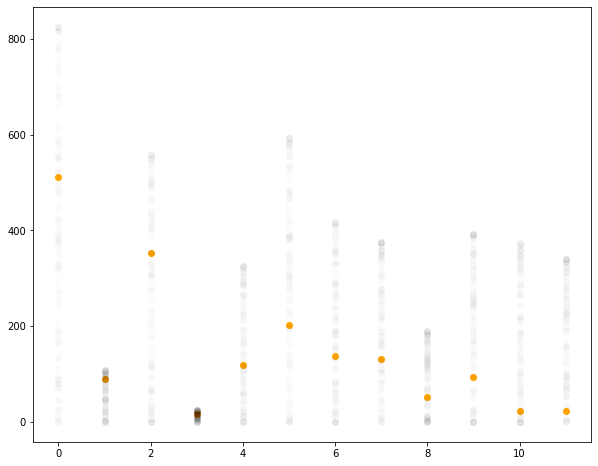

In [45]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(np.arange(len(df)), df['admit'].to_numpy(), 'o', color='orange')
ax.plot(np.arange(len(df)), prior_samples['obs'].T, 'o', color='black', alpha=.01);

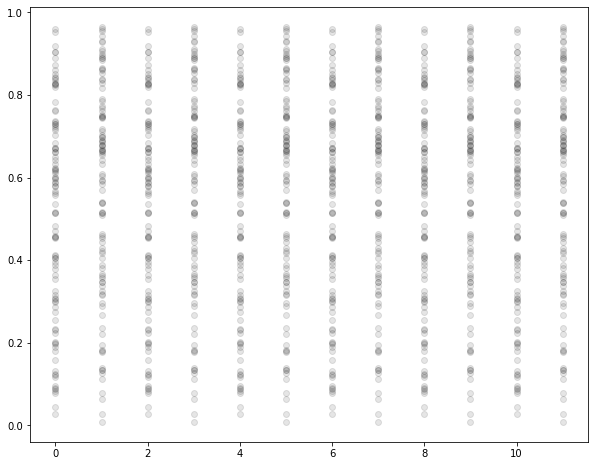

In [46]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(np.arange(len(df)), prior_samples['pbar'].T, 'o', color='black', alpha=.1);

In [48]:
sampler = numpyro.infer.NUTS(model2)
mcmc = numpyro.infer.MCMC(sampler, num_warmup=1000, num_samples=1000, num_chains=4)
mcmc.run(
    jax.random.PRNGKey(0),
    n=df['applications'].to_numpy(),
    obs=df['admit'].to_numpy(),
    gid=(df['applicant.gender']=='male').astype(int).to_numpy()
)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [49]:
mcmc.print_summary(exclude_deterministic=True)


                mean       std    median      5.0%     95.0%     n_eff     r_hat
  alpha[0]     -0.33      0.41     -0.33     -0.98      0.32   5952.47      1.00
  alpha[1]     -0.44      0.41     -0.44     -1.08      0.26   5796.61      1.00
       phi      1.02      0.77      0.85      0.00      2.08   4540.40      1.00
  probs[0]      0.62      0.02      0.62      0.59      0.65   6909.71      1.00
  probs[1]      0.81      0.04      0.82      0.75      0.87   6498.04      1.00
  probs[2]      0.63      0.02      0.63      0.60      0.66   6732.02      1.00
  probs[3]      0.65      0.09      0.66      0.51      0.80   5776.21      1.00
  probs[4]      0.37      0.03      0.37      0.32      0.41   5203.35      1.00
  probs[5]      0.34      0.02      0.34      0.31      0.37   6627.69      1.00
  probs[6]      0.33      0.02      0.33      0.30      0.37   5541.13      1.00
  probs[7]      0.35      0.02      0.35      0.31      0.39   5789.57      1.00
  probs[8]      0.28      0

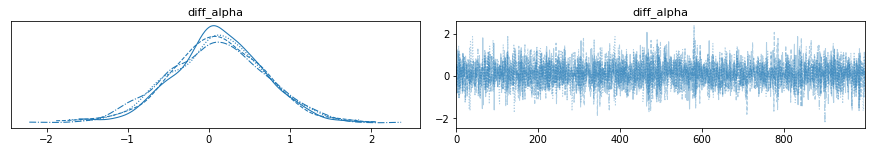

In [51]:
az.plot_trace(az.from_numpyro(mcmc), var_names=['diff_alpha']);

As we were saying, it uses a cumulative distribution, in order to preserve the order.

## 12E3

It'll undercount the error

In [54]:
# e.g.

data = np.hstack([stats.poisson(mu=5).rvs(size=100), np.zeros(10)])

In [72]:
def model(y):
    lograte = numpyro.sample(
        'lograte',
        numpyro.distributions.Normal(0, 1),
    )
    rate = numpyro.deterministic(
        'rate',
        jax.numpy.exp(lograte),
    )
    
    numpyro.sample(
        'obs',
        numpyro.distributions.Poisson(rate=rate),
        obs=y,
    )

In [73]:
prior_pred = numpyro.infer.Predictive(model, num_samples=100)
prior_samples = prior_pred(
    jax.random.PRNGKey(0),
    y=None,
)

In [79]:
sampler = numpyro.infer.NUTS(model)
mcmc = numpyro.infer.MCMC(sampler, num_warmup=1000, num_samples=1000, num_chains=4)
mcmc.run(
    jax.random.PRNGKey(0),
    y=data,
)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [80]:
mcmc.print_summary(exclude_deterministic=False)


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   lograte      1.51      0.04      1.51      1.44      1.59   1416.83      1.00
      rate      4.54      0.20      4.54      4.23      4.88   1420.16      1.00

Number of divergences: 0


In [81]:
sampler = numpyro.infer.NUTS(model)
mcmc = numpyro.infer.MCMC(sampler, num_warmup=1000, num_samples=1000, num_chains=4)
mcmc.run(
    jax.random.PRNGKey(0),
    y=data[:-10],
)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [82]:
mcmc.print_summary(exclude_deterministic=False)


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   lograte      1.61      0.05      1.61      1.54      1.68   1452.38      1.00
      rate      5.00      0.22      4.99      4.65      5.38   1449.66      1.00

Number of divergences: 0


In [83]:
data[:-10]

array([ 5.,  3.,  4.,  5.,  3.,  6.,  3.,  4., 12.,  2.,  5.,  5.,  5.,
        2.,  5.,  3.,  6.,  4.,  5.,  4.,  6.,  7.,  6.,  8.,  2.,  6.,
        4.,  6., 11.,  2.,  3.,  6.,  7.,  2.,  6.,  4.,  5.,  1.,  0.,
        4.,  5.,  8.,  5.,  6.,  4.,  5.,  8.,  7.,  6.,  7.,  4.,  1.,
        3.,  6., 11.,  4.,  3.,  5.,  6.,  4.,  6.,  7.,  2.,  4.,  3.,
        5.,  3.,  6.,  7.,  4.,  3.,  4.,  6.,  8.,  4.,  5.,  8.,  6.,
        3.,  8.,  6.,  3.,  6.,  2.,  9.,  5.,  4.,  5.,  5.,  5.,  6.,
        4.,  8.,  8.,  8.,  4.,  5.,  3.,  0.,  8.])

## 12E4

Overdispersion can happen a lot because perhaps there is some rare condition that needs to be happen for the process to be triggered.

Underdisperion...what comes to mind is if data with low counts are removed from the sample, e.g. if "censored" data points are removed.

## 12M1

In [17]:
data = np.array([12, 36, 7, 41])
datasc = data/np.sum(data)

In [18]:
scipy.special.logit(np.cumsum(datasc))

array([-1.94591015,  0.        ,  0.29376112,         inf])

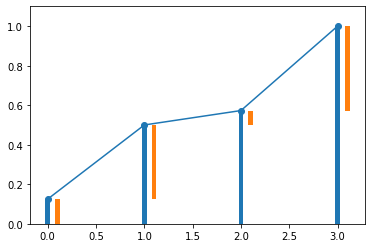

In [26]:
fig, ax = plt.subplots()

ax.plot(np.arange(len(datasc)), np.cumsum(datasc), 'o-');
ax.set_ylim([0, np.sum(datasc)*1.1]);
ax.bar(np.arange(len(datasc)), np.cumsum(datasc), width=.05)
ax.bar(np.arange(len(datasc))+.1, datasc, width=.05, bottom=np.cumsum(datasc)-datasc);

## 12M3

In [24]:
data = np.hstack([stats.binom(n=5, p=.8).rvs(100), np.zeros(100)])
data

array([5., 4., 1., 3., 4., 5., 4., 3., 4., 4., 5., 4., 4., 5., 4., 5., 2.,
       4., 4., 3., 2., 5., 5., 5., 4., 5., 4., 5., 3., 4., 5., 5., 5., 3.,
       4., 4., 4., 4., 5., 4., 4., 5., 3., 4., 4., 4., 5., 4., 4., 5., 5.,
       4., 5., 2., 4., 3., 5., 5., 4., 4., 4., 4., 5., 3., 4., 5., 4., 3.,
       4., 3., 5., 5., 3., 4., 5., 4., 4., 5., 4., 4., 3., 2., 4., 4., 5.,
       4., 5., 4., 3., 3., 3., 4., 4., 5., 4., 3., 3., 4., 4., 5., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [35]:
def model(y):
    
    logitprobs = numpyro.sample(
        'logitprobs',
        numpyro.distributions.Normal(0, 1.5),
    )
    gate = numpyro.sample(
        'gate',
        numpyro.distributions.Beta(1, 1),
    )
    probs = numpyro.deterministic(
        'probs',
        jax.scipy.special.expit(logitprobs),
    )
    
    def scanfn(carry, current):
        i = current
        return (), jax.numpy.log(gate*(i==0) + jax.numpy.exp(jax.numpy.log1p(-gate)+numpyro.distributions.Binomial(5, probs).log_prob(i)))
        
    _, logp = jax.lax.scan(scanfn, (), y)
    
    numpyro.factor(
        'factor',
        logp,
    )

In [36]:
sampler = numpyro.infer.NUTS(model)
mcmc = numpyro.infer.MCMC(sampler, num_warmup=1000, num_samples=1000, num_chains=4)
mcmc.run(
    jax.random.PRNGKey(0),
    y=data,
)
mcmc.print_summary(exclude_deterministic=False);

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]


                  mean       std    median      5.0%     95.0%     n_eff     r_hat
        gate      0.50      0.04      0.50      0.44      0.56   4068.46      1.00
  logitprobs      1.42      0.12      1.41      1.23      1.61   2869.98      1.00
       probs      0.80      0.02      0.80      0.77      0.83   2910.75      1.00

Number of divergences: 0


## 12H1

In [2]:
df = pd.read_csv('Hurricanes.csv', sep=';')

In [3]:
df

,name,year,deaths,category,min_pressure,damage_norm,female,femininity
0,Easy,1950,2,3,960,1590,1,6.77778
1,King,1950,4,3,955,5350,0,1.38889
2,Able,1952,3,1,985,150,0,3.83333
3,Barbara,1953,1,1,987,58,1,9.83333
4,Florence,1953,0,1,985,15,1,8.33333
...,...,...,...,...,...,...,...,...
87,Gustav,2008,52,2,954,4360,0,1.72222
88,Ike,2008,84,2,950,20370,0,1.88889
89,Irene,2011,41,1,952,7110,1,9.27778
90,Isaac,2012,5,1,966,24000,0,1.94444


In [4]:
def model(deaths, femininity):
    alpha = numpyro.sample(
        'alpha',
        numpyro.distributions.Normal(0, 2),
    )
    beta_femininity = numpyro.sample(
        'beta_femininity',
        numpyro.distributions.Normal(0, .1),
    )
    
    rate = numpyro.deterministic(
        'rate',
        jax.numpy.exp(alpha + beta_femininity*femininity),
    )
    
    numpyro.sample(
        'obs',
        numpyro.distributions.Poisson(rate=rate),
        obs=deaths,
    )

In [5]:
prior_pred = numpyro.infer.Predictive(model, num_samples=100)
prior_samples = prior_pred(
    jax.random.PRNGKey(0),
    femininity=df['femininity'].to_numpy(),
    deaths=None,
)

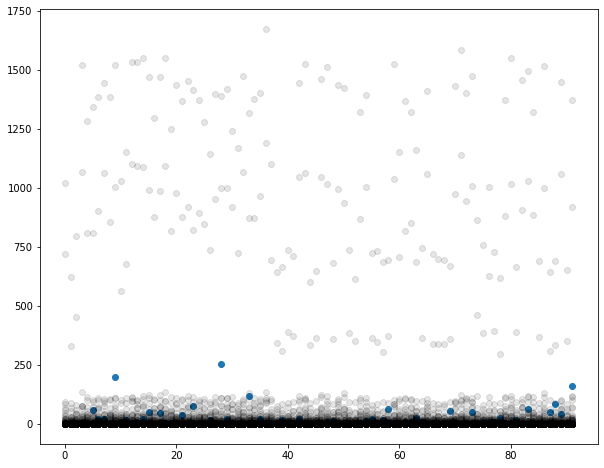

In [6]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(np.arange(len(df)), df['deaths'].to_numpy(), 'o')
ax.plot(np.arange(len(df)), prior_samples['obs'].T, 'o', color='black', alpha=.1);

In [7]:
sampler = numpyro.infer.NUTS(model)
mcmc = numpyro.infer.MCMC(sampler, num_chains=4, num_samples=1000, num_warmup=1000)
mcmc.run(
    jax.random.PRNGKey(0),
    femininity=df['femininity'].to_numpy(),
    deaths=df['deaths'].to_numpy(),
)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [8]:
mcmc.print_summary()


                       mean       std    median      5.0%     95.0%     n_eff     r_hat
            alpha      2.51      0.06      2.51      2.41      2.60    769.52      1.01
  beta_femininity      0.07      0.01      0.07      0.06      0.09    790.62      1.01

Number of divergences: 0


In [9]:
post_pred = numpyro.infer.Predictive(model, mcmc.get_samples())
predictions = post_pred(
    jax.random.PRNGKey(0),
    femininity=df['femininity'].to_numpy(),
    deaths=None,
)

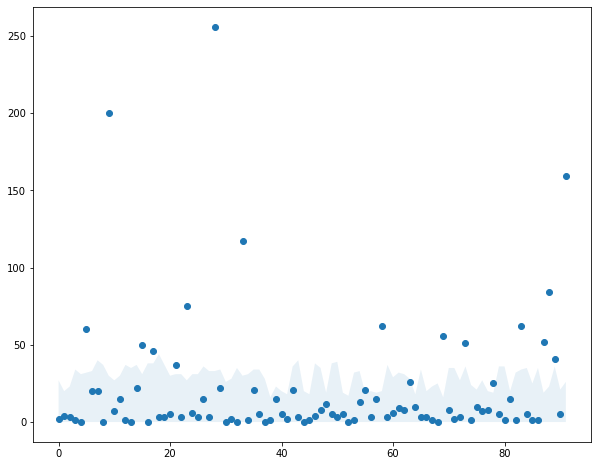

In [10]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(np.arange(len(df)), df['deaths'].to_numpy(), 'o')
ax.fill_between(np.arange(len(df)), *numpyro.diagnostics.hpdi(prior_samples['obs']), alpha=.1);

In [11]:
def model(deaths, femininity):
    alpha = numpyro.sample(
        'alpha',
        numpyro.distributions.Normal(0, 2),
    )
    
    rate = numpyro.deterministic(
        'rate',
        jax.numpy.exp(alpha + 0*femininity),
    )
    
    numpyro.sample(
        'obs',
        numpyro.distributions.Poisson(rate=rate),
        obs=deaths,
    )

In [12]:
prior_pred = numpyro.infer.Predictive(model, num_samples=100)
prior_samples = prior_pred(
    jax.random.PRNGKey(0),
    femininity=df['femininity'].to_numpy(),
    deaths=None,
)

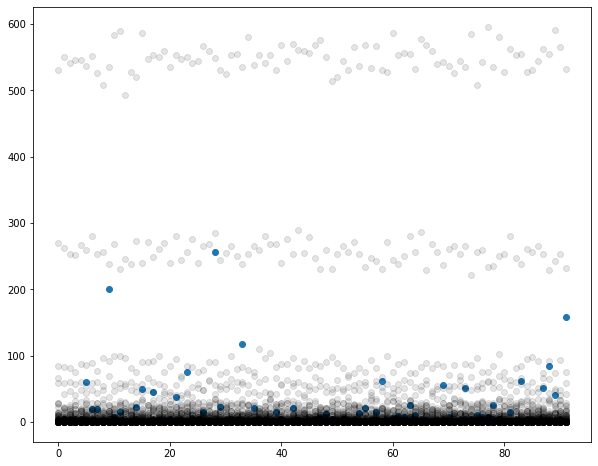

In [13]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(np.arange(len(df)), df['deaths'].to_numpy(), 'o')
ax.plot(np.arange(len(df)), prior_samples['obs'].T, 'o', color='black', alpha=.1);

In [14]:
sampler = numpyro.infer.NUTS(model)
mcmc = numpyro.infer.MCMC(sampler, num_chains=4, num_samples=1000, num_warmup=1000)
mcmc.run(
    jax.random.PRNGKey(0),
    femininity=df['femininity'].to_numpy(),
    deaths=df['deaths'].to_numpy(),
)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [15]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha      3.03      0.02      3.03      2.99      3.06   1415.60      1.00

Number of divergences: 0


In [16]:
post_pred = numpyro.infer.Predictive(model, mcmc.get_samples())
predictions = post_pred(
    jax.random.PRNGKey(0),
    femininity=df['femininity'].to_numpy(),
    deaths=None,
)

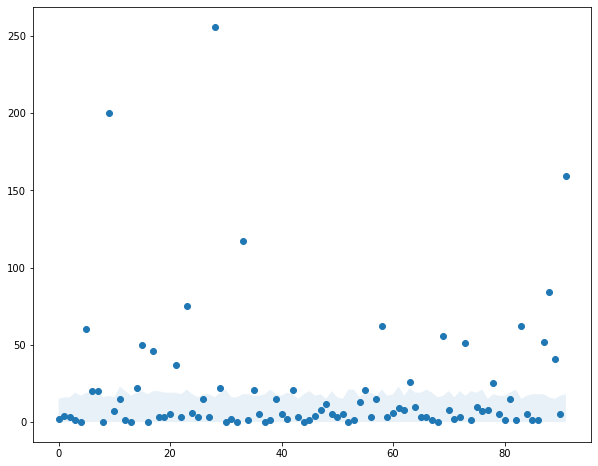

In [17]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(np.arange(len(df)), df['deaths'].to_numpy(), 'o')
ax.fill_between(np.arange(len(df)), *numpyro.diagnostics.hpdi(prior_samples['obs']), alpha=.1);

In [18]:
def model(deaths, femininity):
    alpha = numpyro.sample(
        'alpha',
        numpyro.distributions.Normal(0, 2),
    )
    beta_femininity = numpyro.sample(
        'beta_femininity',
        numpyro.distributions.Normal(0, .1),
    )
    concentration = numpyro.sample(
        'concentration',
        numpyro.distributions.Exponential(rate=2.),
    )
    
    rate = numpyro.deterministic(
        'rate',
        jax.numpy.exp(alpha + beta_femininity*femininity),
    )
    
    numpyro.sample(
        'obs',
        numpyro.distributions.GammaPoisson(concentration=concentration, rate=rate),
        obs=deaths,
    )

In [19]:
prior_pred = numpyro.infer.Predictive(model, num_samples=100)
prior_samples = prior_pred(
    jax.random.PRNGKey(0),
    femininity=df['femininity'].to_numpy(),
    deaths=None,
)

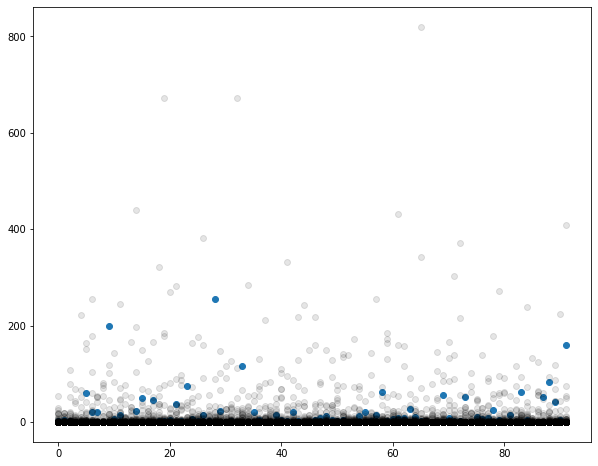

In [20]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(np.arange(len(df)), df['deaths'].to_numpy(), 'o')
ax.plot(np.arange(len(df)), prior_samples['obs'].T, 'o', color='black', alpha=.1);

In [21]:
sampler = numpyro.infer.NUTS(model)
mcmc = numpyro.infer.MCMC(sampler, num_chains=4, num_samples=1000, num_warmup=1000)
mcmc.run(
    jax.random.PRNGKey(0),
    femininity=df['femininity'].to_numpy(),
    deaths=df['deaths'].to_numpy(),
)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [22]:
mcmc.print_summary()


                       mean       std    median      5.0%     95.0%     n_eff     r_hat
            alpha     -3.36      0.36     -3.35     -3.99     -2.83   1323.98      1.00
  beta_femininity     -0.07      0.04     -0.06     -0.14      0.01   1515.79      1.00
    concentration      0.45      0.06      0.45      0.36      0.55   1776.88      1.00

Number of divergences: 0


In [23]:
post_pred = numpyro.infer.Predictive(model, mcmc.get_samples())
predictions = post_pred(
    jax.random.PRNGKey(0),
    femininity=df['femininity'].to_numpy(),
    deaths=None,
)

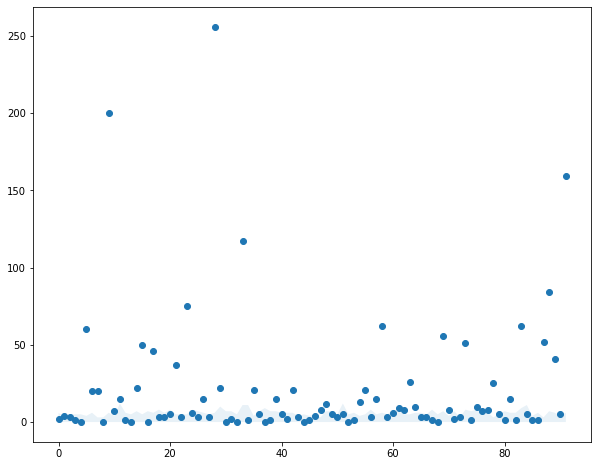

In [24]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(np.arange(len(df)), df['deaths'].to_numpy(), 'o')
ax.fill_between(np.arange(len(df)), *numpyro.diagnostics.hpdi(prior_samples['obs']), alpha=.1);

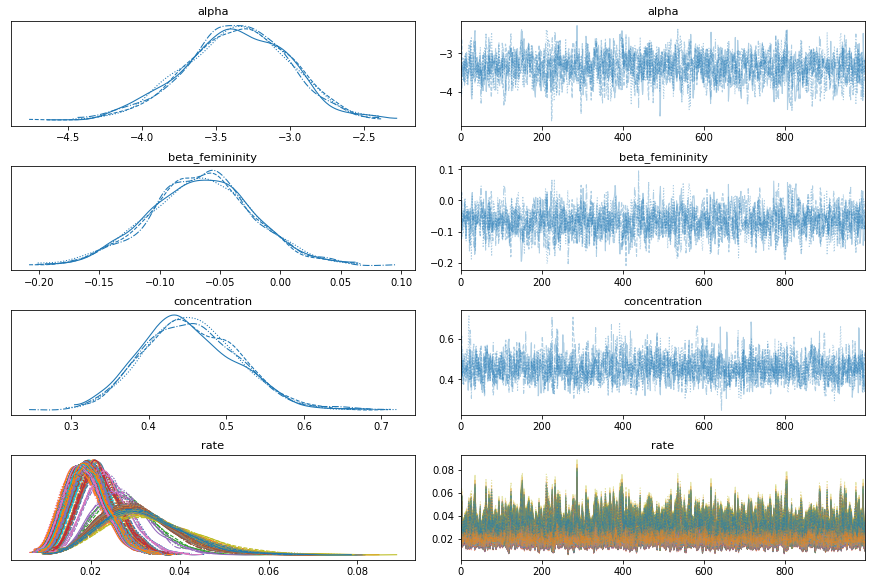

In [25]:
az.plot_trace(az.from_numpyro(mcmc));

In [26]:
df

,name,year,deaths,category,min_pressure,damage_norm,female,femininity
0,Easy,1950,2,3,960,1590,1,6.77778
1,King,1950,4,3,955,5350,0,1.38889
2,Able,1952,3,1,985,150,0,3.83333
3,Barbara,1953,1,1,987,58,1,9.83333
4,Florence,1953,0,1,985,15,1,8.33333
...,...,...,...,...,...,...,...,...
87,Gustav,2008,52,2,954,4360,0,1.72222
88,Ike,2008,84,2,950,20370,0,1.88889
89,Irene,2011,41,1,952,7110,1,9.27778
90,Isaac,2012,5,1,966,24000,0,1.94444


## 12H3

In [27]:
# femininity and damage norm

In [28]:
def scale(feat):
    return (feat - np.mean(feat))/np.std(feat)

In [29]:
def model(deaths, femininity, damage):
    alpha = numpyro.sample(
        'alpha',
        numpyro.distributions.Normal(0, 2),
    )
    beta_femininity = numpyro.sample(
        'beta_femininity',
        numpyro.distributions.Normal(0, .5),
    )
    beta_damage = numpyro.sample(
        'beta_damage',
        numpyro.distributions.Normal(0, .5),
    )
    beta_femdamage = numpyro.sample(
        'beta_femdamage',
        numpyro.distributions.Normal(0, .1),
    )
    concentration = numpyro.sample(
        'concentration',
        numpyro.distributions.Exponential(rate=2.),
    )
    
    rate = numpyro.deterministic(
        'rate',
        jax.numpy.exp(
            alpha
            + beta_femininity*femininity
            + beta_damage*damage
            + beta_femdamage*femininity*damage
        ),
    )
    
    numpyro.sample(
        'obs',
        numpyro.distributions.GammaPoisson(concentration=concentration, rate=rate),
        obs=deaths,
    )

In [30]:
femininity_sc = scale(df['femininity'].to_numpy())
damage_sc = scale(df['damage_norm'].to_numpy())
prior_pred = numpyro.infer.Predictive(model, num_samples=100)
prior_samples = prior_pred(
    jax.random.PRNGKey(0),
    femininity=femininity_sc,
    damage=damage_sc,
    deaths=None,
)

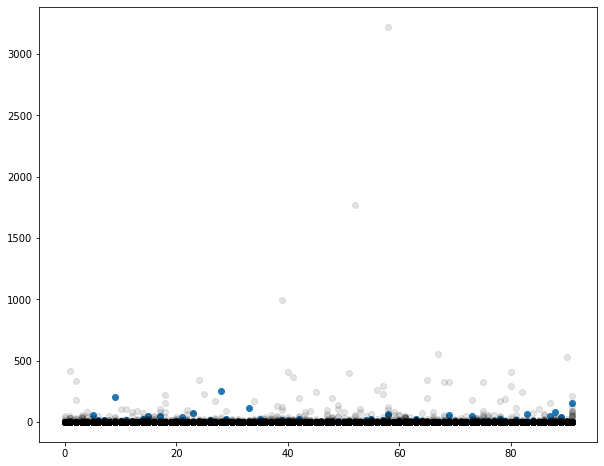

In [31]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(np.arange(len(df)), df['deaths'].to_numpy(), 'o')
ax.plot(np.arange(len(df)), prior_samples['obs'].T, 'o', color='black', alpha=.1);

In [32]:
sampler = numpyro.infer.NUTS(model)
mcmc = numpyro.infer.MCMC(sampler, num_chains=4, num_samples=1000, num_warmup=1000)
mcmc.run(
    jax.random.PRNGKey(0),
    femininity=femininity_sc,
    damage=damage_sc,
    deaths=df['deaths'].to_numpy(),
)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [33]:
mcmc.print_summary()


                       mean       std    median      5.0%     95.0%     n_eff     r_hat
            alpha     -2.99      0.20     -2.99     -3.32     -2.68   2513.48      1.00
      beta_damage     -1.07      0.20     -1.06     -1.37     -0.72   3987.81      1.00
   beta_femdamage     -0.06      0.09     -0.06     -0.21      0.09   4404.43      1.00
  beta_femininity     -0.10      0.12     -0.10     -0.30      0.10   4079.65      1.00
    concentration      0.68      0.10      0.67      0.52      0.85   2662.17      1.00

Number of divergences: 0


In [34]:
post_pred = numpyro.infer.Predictive(model, mcmc.get_samples())
predictions = post_pred(
    jax.random.PRNGKey(0),
    femininity=femininity_sc,
    damage=damage_sc,
    deaths=None,
)

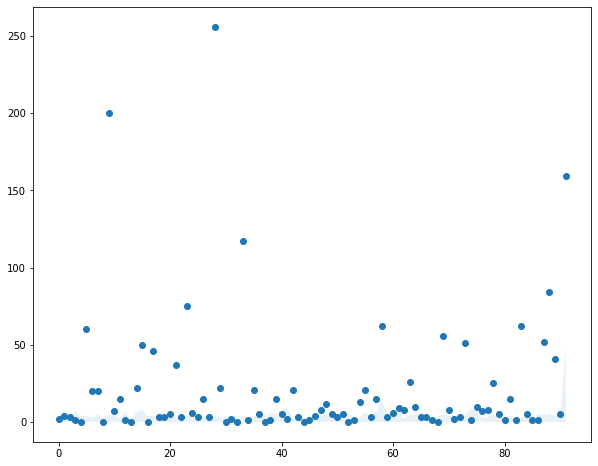

In [35]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(np.arange(len(df)), df['deaths'].to_numpy(), 'o')
ax.fill_between(np.arange(len(df)), *numpyro.diagnostics.hpdi(prior_samples['obs']), alpha=.1);

In [36]:
az.waic(az.from_numpyro(mcmc))

/home/marco/miniconda3/envs/good-bayesian/lib/python3.8/site-packages/arviz/stats/stats.py:1405: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 4000 by 92 log-likelihood matrix

          Estimate       SE
elpd_waic  -335.24    16.41
p_waic        5.34        -

There has been a warning during the calculation. Please check the results.

In [37]:
def model(deaths, femininity, damage, pressure):
    alpha = numpyro.sample(
        'alpha',
        numpyro.distributions.Normal(0, 2),
    )
    beta_femininity = numpyro.sample(
        'beta_femininity',
        numpyro.distributions.Normal(0, .5),
    )
    beta_damage = numpyro.sample(
        'beta_damage',
        numpyro.distributions.Normal(0, .5),
    )
    beta_pressure = numpyro.sample(
        'beta_pressure',
        numpyro.distributions.Normal(0, .5),
    )
    beta_femdamage = numpyro.sample(
        'beta_femdamage',
        numpyro.distributions.Normal(0, .1),
    )
    beta_fempressure = numpyro.sample(
        'beta_fempressure',
        numpyro.distributions.Normal(0, .1),
    )
    concentration = numpyro.sample(
        'concentration',
        numpyro.distributions.Exponential(rate=2.),
    )
    
    rate = numpyro.deterministic(
        'rate',
        jax.numpy.exp(
            alpha
            + beta_femininity*femininity
            + beta_damage*damage
            + beta_pressure*pressure
            + beta_femdamage*femininity*damage
            + beta_fempressure*femininity*pressure
        ),
    )
    
    numpyro.sample(
        'obs',
        numpyro.distributions.GammaPoisson(concentration=concentration, rate=rate),
        obs=deaths,
    )

In [38]:
femininity_sc = scale(df['femininity'].to_numpy())
damage_sc = scale(df['damage_norm'].to_numpy())
pressure_sc = scale(df['min_pressure'].to_numpy())
prior_pred = numpyro.infer.Predictive(model, num_samples=100)
prior_samples = prior_pred(
    jax.random.PRNGKey(0),
    femininity=femininity_sc,
    damage=damage_sc,
    pressure=pressure_sc,
    deaths=None,
)

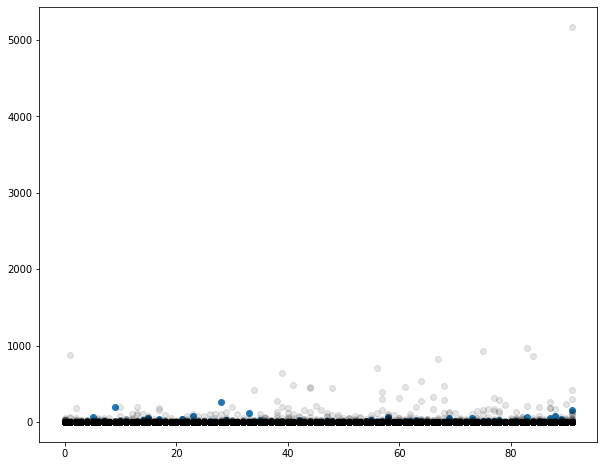

In [39]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(np.arange(len(df)), df['deaths'].to_numpy(), 'o')
ax.plot(np.arange(len(df)), prior_samples['obs'].T, 'o', color='black', alpha=.1);

In [40]:
sampler = numpyro.infer.NUTS(model)
mcmc = numpyro.infer.MCMC(sampler, num_chains=4, num_samples=1000, num_warmup=1000)
mcmc.run(
    jax.random.PRNGKey(0),
    femininity=femininity_sc,
    damage=damage_sc,
    pressure=pressure_sc,
    deaths=df['deaths'].to_numpy(),
)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [41]:
mcmc.print_summary()


                        mean       std    median      5.0%     95.0%     n_eff     r_hat
             alpha     -2.90      0.20     -2.89     -3.23     -2.59   2639.72      1.00
       beta_damage     -0.89      0.20     -0.89     -1.24     -0.58   4007.36      1.00
    beta_femdamage     -0.09      0.09     -0.09     -0.24      0.06   4106.96      1.00
   beta_femininity     -0.12      0.12     -0.13     -0.32      0.09   4014.02      1.00
  beta_fempressure     -0.05      0.08     -0.05     -0.19      0.08   4092.91      1.00
     beta_pressure      0.35      0.13      0.34      0.12      0.56   3746.97      1.00
     concentration      0.71      0.11      0.71      0.53      0.87   2726.15      1.00

Number of divergences: 0


In [42]:
post_pred = numpyro.infer.Predictive(model, mcmc.get_samples())
predictions = post_pred(
    jax.random.PRNGKey(0),
    femininity=femininity_sc,
    damage=damage_sc,
    pressure=pressure_sc,
    deaths=None,
)

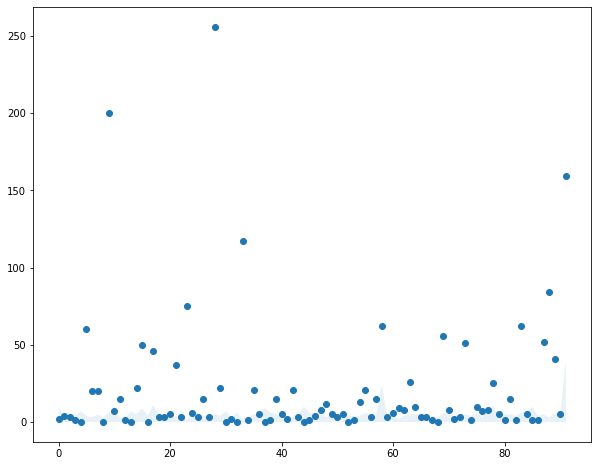

In [43]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(np.arange(len(df)), df['deaths'].to_numpy(), 'o')
ax.fill_between(np.arange(len(df)), *numpyro.diagnostics.hpdi(prior_samples['obs']), alpha=.1);

In [44]:
az.waic(az.from_numpyro(mcmc))

/home/marco/miniconda3/envs/good-bayesian/lib/python3.8/site-packages/arviz/stats/stats.py:1405: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 4000 by 92 log-likelihood matrix

          Estimate       SE
elpd_waic  -334.59    18.45
p_waic        8.45        -

There has been a warning during the calculation. Please check the results.

In [45]:
def model(deaths, femininity, pressure):
    alpha = numpyro.sample(
        'alpha',
        numpyro.distributions.Normal(0, 2),
    )
    beta_femininity = numpyro.sample(
        'beta_femininity',
        numpyro.distributions.Normal(0, .5),
    )
    beta_pressure = numpyro.sample(
        'beta_pressure',
        numpyro.distributions.Normal(0, .5),
    )
    beta_fempressure = numpyro.sample(
        'beta_fempressure',
        numpyro.distributions.Normal(0, .1),
    )
    concentration = numpyro.sample(
        'concentration',
        numpyro.distributions.Exponential(rate=2.),
    )
    
    rate = numpyro.deterministic(
        'rate',
        jax.numpy.exp(
            alpha
            + beta_femininity*femininity
            + beta_pressure*pressure
            + beta_fempressure*femininity*pressure
        ),
    )
    
    numpyro.sample(
        'obs',
        numpyro.distributions.GammaPoisson(concentration=concentration, rate=rate),
        obs=deaths,
    )

In [46]:
femininity_sc = scale(df['femininity'].to_numpy())
pressure_sc = scale(df['min_pressure'].to_numpy())
prior_pred = numpyro.infer.Predictive(model, num_samples=100)
prior_samples = prior_pred(
    jax.random.PRNGKey(0),
    femininity=femininity_sc,
    pressure=pressure_sc,
    deaths=None,
)

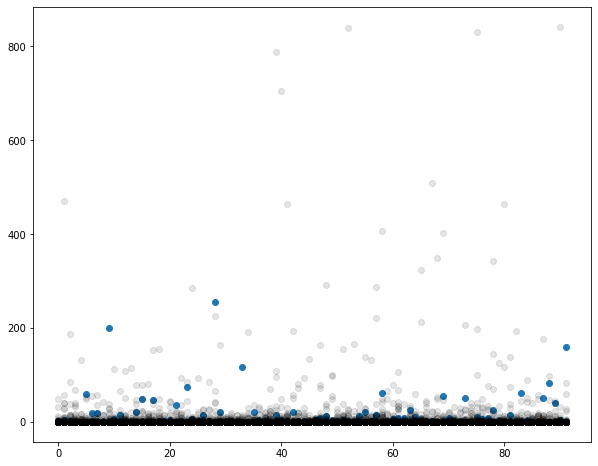

In [47]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(np.arange(len(df)), df['deaths'].to_numpy(), 'o')
ax.plot(np.arange(len(df)), prior_samples['obs'].T, 'o', color='black', alpha=.1);

In [48]:
sampler = numpyro.infer.NUTS(model)
mcmc = numpyro.infer.MCMC(sampler, num_chains=4, num_samples=1000, num_warmup=1000)
mcmc.run(
    jax.random.PRNGKey(0),
    femininity=femininity_sc,
    pressure=pressure_sc,
    deaths=df['deaths'].to_numpy(),
)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [49]:
mcmc.print_summary()


                        mean       std    median      5.0%     95.0%     n_eff     r_hat
             alpha     -3.39      0.21     -3.38     -3.73     -3.05   2660.41      1.00
   beta_femininity     -0.27      0.14     -0.27     -0.50     -0.05   4302.99      1.00
  beta_fempressure     -0.09      0.08     -0.09     -0.22      0.04   4575.06      1.00
     beta_pressure      0.58      0.13      0.58      0.36      0.79   4284.06      1.00
     concentration      0.55      0.08      0.55      0.43      0.68   2849.32      1.00

Number of divergences: 0


In [50]:
post_pred = numpyro.infer.Predictive(model, mcmc.get_samples())
predictions = post_pred(
    jax.random.PRNGKey(0),
    femininity=femininity_sc,
    pressure=pressure_sc,
    deaths=None,
)

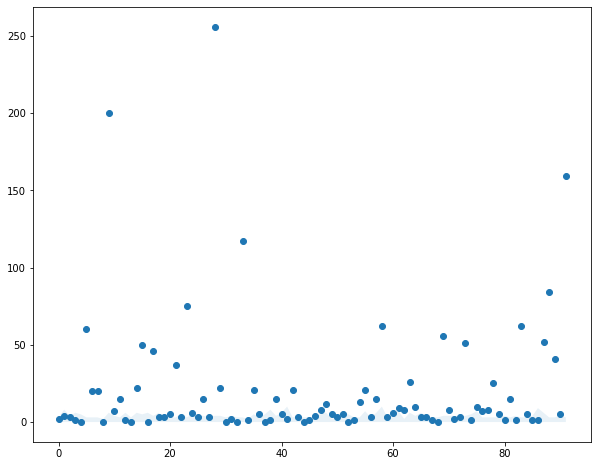

In [51]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(np.arange(len(df)), df['deaths'].to_numpy(), 'o')
ax.fill_between(np.arange(len(df)), *numpyro.diagnostics.hpdi(prior_samples['obs']), alpha=.1);

In [52]:
az.waic(az.from_numpyro(mcmc))

/home/marco/miniconda3/envs/good-bayesian/lib/python3.8/site-packages/arviz/stats/stats.py:1405: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 4000 by 92 log-likelihood matrix

          Estimate       SE
elpd_waic  -347.74    19.78
p_waic        8.24        -

There has been a warning during the calculation. Please check the results.

In [53]:
# all of these models show some overlap with zero for the beta femininity

## 12H4

In [54]:
def model(deaths, femininity, logdamage, pressure):
    alpha = numpyro.sample(
        'alpha',
        numpyro.distributions.Normal(0, 2),
    )
    beta_femininity = numpyro.sample(
        'beta_femininity',
        numpyro.distributions.Normal(0, .5),
    )
    beta_damage = numpyro.sample(
        'beta_damage',
        numpyro.distributions.Normal(0, .5),
    )
    beta_pressure = numpyro.sample(
        'beta_pressure',
        numpyro.distributions.Normal(0, .5),
    )
    beta_femdamage = numpyro.sample(
        'beta_femdamage',
        numpyro.distributions.Normal(0, .1),
    )
    beta_fempressure = numpyro.sample(
        'beta_fempressure',
        numpyro.distributions.Normal(0, .1),
    )
    concentration = numpyro.sample(
        'concentration',
        numpyro.distributions.Exponential(rate=2.),
    )
    
    rate = numpyro.deterministic(
        'rate',
        jax.numpy.exp(
            alpha
            + beta_femininity*femininity
            + beta_damage*logdamage
            + beta_pressure*pressure
            + beta_femdamage*femininity*logdamage
            + beta_fempressure*femininity*pressure
        ),
    )
    
    numpyro.sample(
        'obs',
        numpyro.distributions.GammaPoisson(concentration=concentration, rate=rate),
        obs=deaths,
    )

In [55]:
femininity_sc = scale(df['femininity'].to_numpy())
pressure_sc = scale(df['min_pressure'].to_numpy())
prior_pred = numpyro.infer.Predictive(model, num_samples=100)
prior_samples = prior_pred(
    jax.random.PRNGKey(0),
    femininity=femininity_sc,
    logdamage=np.log(df['damage_norm'].to_numpy()),
    pressure=pressure_sc,
    deaths=None,
)

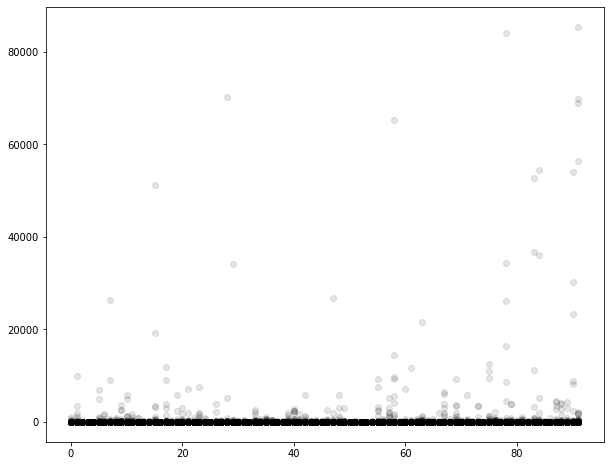

In [56]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(np.arange(len(df)), df['deaths'].to_numpy(), 'o')
ax.plot(np.arange(len(df)), prior_samples['obs'].T, 'o', color='black', alpha=.1);

In [60]:
sampler = numpyro.infer.NUTS(model)
mcmc = numpyro.infer.MCMC(sampler, num_chains=4, num_samples=1000, num_warmup=1000)
mcmc.run(
    jax.random.PRNGKey(0),
    femininity=femininity_sc,
    logdamage=np.log(df['damage_norm'].to_numpy()),
    pressure=pressure_sc,
    deaths=df['deaths'].to_numpy(),
)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [61]:
mcmc.print_summary()


                        mean       std    median      5.0%     95.0%     n_eff     r_hat
             alpha      1.63      0.55      1.64      0.70      2.52   2095.61      1.00
       beta_damage     -0.55      0.07     -0.55     -0.65     -0.44   2176.09      1.00
    beta_femdamage     -0.04      0.04     -0.04     -0.10      0.03   1846.55      1.00
   beta_femininity      0.20      0.32      0.21     -0.32      0.72   1898.72      1.00
  beta_fempressure      0.02      0.08      0.02     -0.10      0.16   2881.37      1.00
     beta_pressure      0.06      0.13      0.06     -0.14      0.28   2546.78      1.00
     concentration      0.99      0.16      0.98      0.74      1.25   2836.66      1.00

Number of divergences: 0


In [62]:
post_pred = numpyro.infer.Predictive(model, mcmc.get_samples())
predictions = post_pred(
    jax.random.PRNGKey(0),
    femininity=femininity_sc,
    logdamage=np.log(df['damage_norm'].to_numpy()),
    pressure=pressure_sc,
    deaths=None,
)

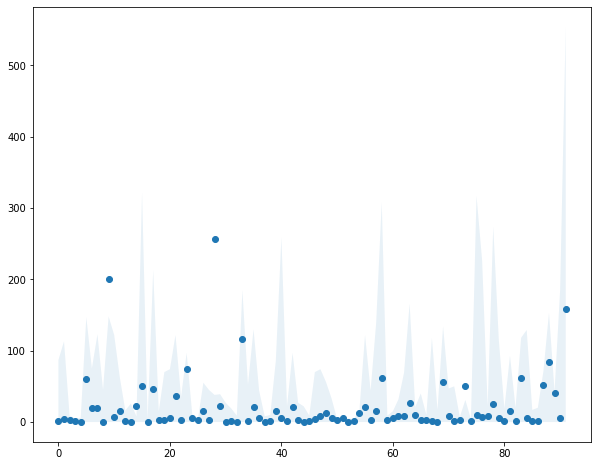

In [63]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(np.arange(len(df)), df['deaths'].to_numpy(), 'o')
ax.fill_between(np.arange(len(df)), *numpyro.diagnostics.hpdi(prior_samples['obs']), alpha=.1);

In [64]:
az.waic(az.from_numpyro(mcmc))

/home/marco/miniconda3/envs/good-bayesian/lib/python3.8/site-packages/arviz/stats/stats.py:1405: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 4000 by 92 log-likelihood matrix

          Estimate       SE
elpd_waic  -316.64    15.89
p_waic        6.49        -

There has been a warning during the calculation. Please check the results.

In [65]:
# cool, finally a model which looks decent!
# and...it shows virtually no effect of femininity

## 12H5

In [2]:
df = pd.read_csv('Trolley.csv', sep=';')

In [3]:
df

,case,response,order,id,age,male,edu,action,intention,contact,story,action2
0,cfaqu,4,2,96;434,14,0,Middle School,0,0,1,aqu,1
1,cfbur,3,31,96;434,14,0,Middle School,0,0,1,bur,1
2,cfrub,4,16,96;434,14,0,Middle School,0,0,1,rub,1
3,cibox,3,32,96;434,14,0,Middle School,0,1,1,box,1
4,cibur,3,4,96;434,14,0,Middle School,0,1,1,bur,1
...,...,...,...,...,...,...,...,...,...,...,...,...
9925,ilpon,3,23,98;299,66,1,Graduate Degree,0,1,0,pon,0
9926,ilsha,6,15,98;299,66,1,Graduate Degree,0,1,0,sha,0
9927,ilshi,7,7,98;299,66,1,Graduate Degree,0,1,0,shi,0
9928,ilswi,2,18,98;299,66,1,Graduate Degree,0,1,0,swi,0


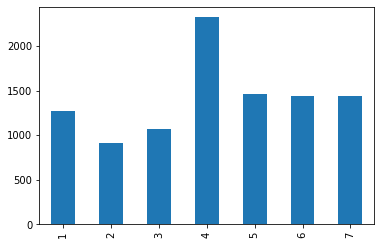

In [4]:
df['response'].value_counts().sort_index().plot(kind='bar', orientation='vertical');

In [5]:
# predict contact using intercepts for male and females?
# could also use interaction with age?
# need to read what the others mean, really.

# what we want to see is whether men and women react differently to whether contact is in
# there. we need to measure their response.
# so, we need this ordered logit.

# first, let's just try modelling the response based on gender

In [6]:
# first, we need to understand the distribution!

In [7]:
from collections import Counter
samples = numpyro.distributions.OrderedLogistic(2, jax.numpy.array([0, .5, 1])).sample(jax.random.PRNGKey(0), sample_shape=(10000,))

In [8]:
# so, here...we take expit of those,
expits = scipy.special.expit(np.array([0, .5, 1])-2)  # OK, so I expect about half samples to be...zero. wait, where's the extra category coming from?
# .5 chance of being 0, .62 of it being 0 or 1, .73 of 0 1 2, and 100% of it being 0123
padded = np.hstack([0, expits, 1])
padded[1:] - padded[:-1]

array([0.11920292, 0.0632226 , 0.0865159 , 0.73105858])

In [9]:
pd.Series(samples).value_counts(normalize=True).sort_index()

0    0.1208
1    0.0613
2    0.0875
3    0.7304
dtype: float64

In [10]:
# this kinda makes sense - it ensures that the right number of things are positive

In [11]:
# nice, this makes sense!!!! wooohoooo!!!!!

In [8]:
nclasses = df['response'].nunique()

In [9]:
nclasses

7

In [10]:
def model(response, gender_contact_id):
    
    alpha_gender_contact = numpyro.sample(
        'alpha_gender',
        numpyro.distributions.Normal(0, 1),
        sample_shape=(4,),
    )
    pred = numpyro.deterministic(
        'pred',
        alpha_gender_contact[gender_contact_id],
    )
    cutpoints = numpyro.sample(
        'cutpoints',
        numpyro.distributions.TransformedDistribution(
            numpyro.distributions.Normal(0, 5).expand([nclasses - 1]),
            numpyro.distributions.transforms.OrderedTransform()
        )
    )
    
    numpyro.sample(
        'obs',
        numpyro.distributions.OrderedLogistic(pred, cutpoints),
        obs=response,
    )

In [11]:
prior_pred = numpyro.infer.Predictive(model, num_samples=100)
prior_samples = prior_pred(
    jax.random.PRNGKey(0),
    response=None,
    gender_contact_id=(df['male']*2+df['contact']).to_numpy()
)

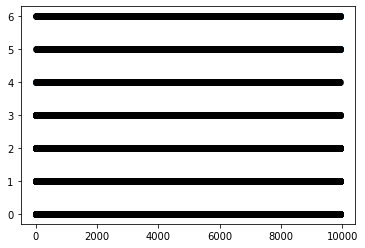

In [12]:
fig, ax = plt.subplots()

ax.plot(np.arange(len(df)), df['response'].to_numpy()-1, 'o')
ax.plot(np.arange(len(df)), prior_samples['obs'].T, 'o', color='black', alpha=.01);

In [13]:
pd.Series(prior_samples['obs'][:, 0]).value_counts()

0    52
1    15
2    14
3    10
4     3
5     3
6     3
dtype: int64

In [14]:
sampler = numpyro.infer.NUTS(model)
mcmc = numpyro.infer.MCMC(sampler, num_chains=4, num_samples=1000, num_warmup=1000)
mcmc.run(
    jax.random.PRNGKey(0),
    response=df['response'].to_numpy()-1,
    gender_contact_id=(df['male']*2+df['contact']).to_numpy()
)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [15]:
mcmc.print_summary()


                     mean       std    median      5.0%     95.0%     n_eff     r_hat
alpha_gender[0]      0.02      0.50      0.02     -0.82      0.82    845.00      1.00
alpha_gender[1]     -0.46      0.50     -0.45     -1.27      0.39    844.54      1.00
alpha_gender[2]      0.61      0.50      0.61     -0.17      1.48    842.81      1.00
alpha_gender[3]     -0.08      0.50     -0.07     -0.95      0.71    854.28      1.00
   cutpoints[0]     -1.74      0.50     -1.73     -2.61     -0.95    839.34      1.00
   cutpoints[1]     -1.08      0.50     -1.07     -1.87     -0.22    842.53      1.00
   cutpoints[2]     -0.52      0.50     -0.52     -1.35      0.30    843.02      1.00
   cutpoints[3]      0.48      0.50      0.49     -0.34      1.32    846.04      1.00
   cutpoints[4]      1.14      0.50      1.15      0.34      2.00    844.35      1.00
   cutpoints[5]      2.05      0.50      2.05      1.18      2.83    838.41      1.00

Number of divergences: 0


In [72]:
# ok, this makes no sense, I should understand the data first.

In [20]:
trace = mcmc.get_samples()

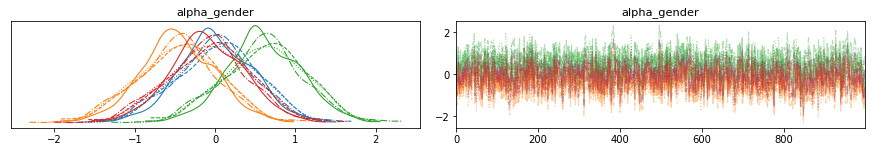

In [16]:
az.plot_trace(az.from_numpyro(mcmc), var_names=['alpha_gender']);

In [21]:
df.groupby(['male', 'contact'])['response'].sum()

male  contact
0     0          13528
      1           2922
1     0          20841
      1           4408
Name: response, dtype: int64

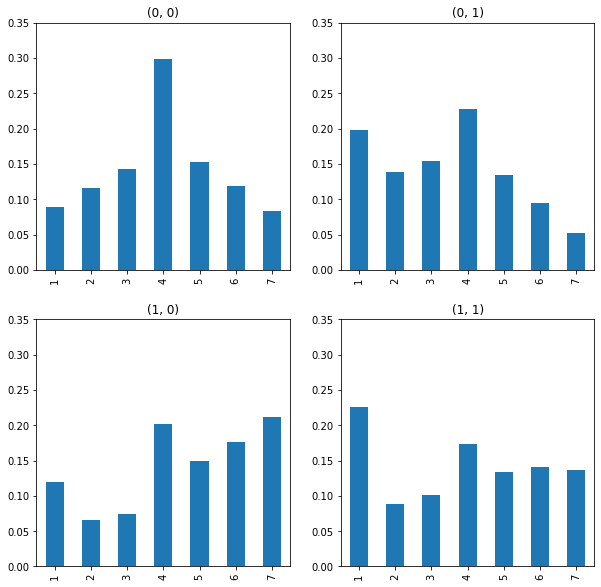

In [30]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
ax = ax.flatten()
for idx, (key, val) in enumerate(df.groupby(['male', 'contact'])):
    val['response'].value_counts(normalize=True).sort_index().plot(kind='bar', ax=ax[idx])
    ax[idx].set_title(key)
    ax[idx].set_ylim([0, .35])

In [32]:
trace = mcmc.get_samples()

In [37]:
expits = jax.scipy.special.expit(trace['cutpoints'].mean(axis=0) - (-.08))

In [38]:
expits

DeviceArray([0.15996806, 0.2686573 , 0.3916056 , 0.635825  , 0.7722438 ,
             0.89331883], dtype=float32)

In [40]:
padded = jax.numpy.hstack([0, expits, 1])
padded[1:] - padded[:-1]

DeviceArray([0.15996806, 0.10868923, 0.12294829, 0.24421939, 0.13641882,
             0.12107503, 0.10668117], dtype=float32)

## 12 H6

In [3]:
df = pd.read_csv('Fish.csv', sep=';')

In [4]:
df

,fish_caught,livebait,camper,persons,child,hours
0,0,0,0,1,0,21.124
1,0,1,1,1,0,5.732
2,0,1,0,1,0,1.323
3,0,1,1,2,1,0.548
4,1,1,0,1,0,1.695
...,...,...,...,...,...,...
245,0,1,1,2,0,10.219
246,0,1,1,4,3,0.004
247,0,1,1,2,1,1.969
248,0,1,1,3,2,0.075


In [29]:
df['livebait'].value_counts()

1    216
0     34
Name: livebait, dtype: int64

In [5]:
# livebait seems relevant. camper...dunno. persons...aybe. child...probably. hours...yeah, I guess.
# but I can't use hours as a predictor, it needs to be used to make the offset. Cool problem! But, will have to come back to it?

In [6]:
log_hours = np.log(df['hours'].to_numpy())

In [30]:
def model(fish_caught, log_hours, livebait_id):
    livebait = numpyro.sample(
        'livebait',
        numpyro.distributions.Normal(0, 1),
        sample_shape=(2,),
    )
    
    log_rate = log_hours + livebait[livebait_id]
    rate = numpyro.deterministic(
        'rate',
        jax.numpy.exp(log_rate),
    )
    
    logit_gate = numpyro.sample(
        'logit_gate',
        numpyro.distributions.Normal(0, 1),
    )
    gate = numpyro.deterministic(
        'gate',
        jax.scipy.special.expit(logit_gate)
    )
    
    numpyro.sample(
        'obs',
        numpyro.distributions.ZeroInflatedPoisson(gate=gate, rate=rate),
        obs=fish_caught,
    )

In [32]:
prior_pred = numpyro.infer.Predictive(model, num_samples=100)
prior_samples = prior_pred(
    jax.random.PRNGKey(0),
    fish_caught=None,
    livebait_id=df['livebait'].to_numpy(),
    log_hours=log_hours,
)

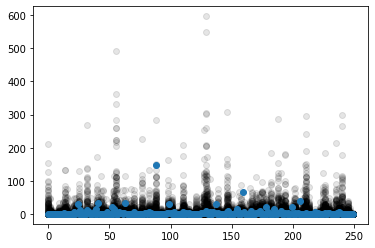

In [33]:
fig, ax = plt.subplots()
ax.plot(np.arange(len(df)), prior_samples['obs'].T, 'o', color='black', alpha=.1)
ax.plot(np.arange(len(df)), df['fish_caught'].to_numpy(), 'o');

In [35]:
sampler = numpyro.infer.NUTS(model)
mcmc = numpyro.infer.MCMC(sampler, num_chains=4, num_samples=1000, num_warmup=1000)
mcmc.run(
    jax.random.PRNGKey(0),
    log_hours=log_hours,
    fish_caught=df['fish_caught'].to_numpy(),
    livebait_id=df['livebait'].to_numpy(),
)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [37]:
mcmc.print_summary()


                  mean       std    median      5.0%     95.0%     n_eff     r_hat
 livebait[0]     -1.56      0.24     -1.55     -1.96     -1.19   4510.57      1.00
 livebait[1]     -0.08      0.03     -0.08     -0.14     -0.02   3860.22      1.00
  logit_gate     -0.81      0.18     -0.81     -1.12     -0.52   4182.37      1.00

Number of divergences: 0


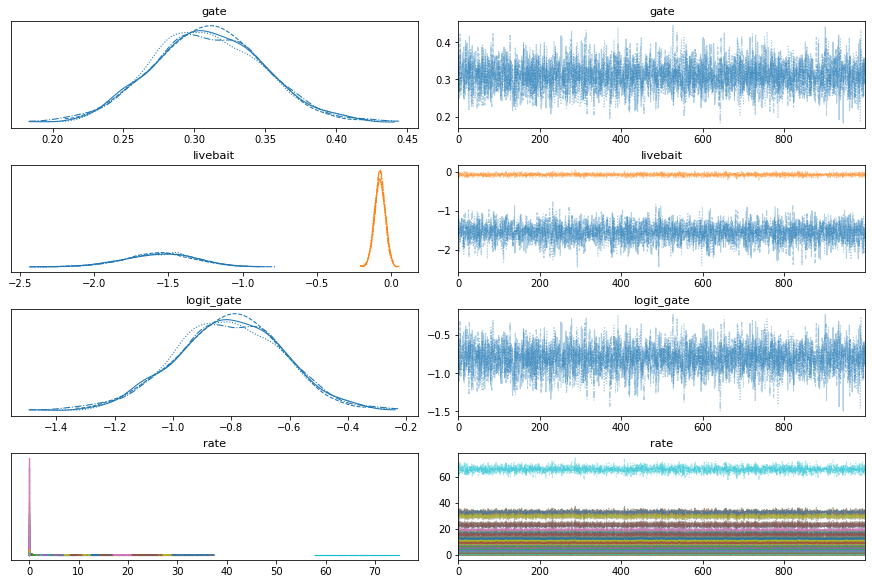

In [38]:
az.plot_trace(az.from_numpyro(mcmc));

## 12H7

In [2]:
df = pd.read_csv('Trolley.csv', sep=';')

In [3]:
df

,case,response,order,id,age,male,edu,action,intention,contact,story,action2
0,cfaqu,4,2,96;434,14,0,Middle School,0,0,1,aqu,1
1,cfbur,3,31,96;434,14,0,Middle School,0,0,1,bur,1
2,cfrub,4,16,96;434,14,0,Middle School,0,0,1,rub,1
3,cibox,3,32,96;434,14,0,Middle School,0,1,1,box,1
4,cibur,3,4,96;434,14,0,Middle School,0,1,1,bur,1
...,...,...,...,...,...,...,...,...,...,...,...,...
9925,ilpon,3,23,98;299,66,1,Graduate Degree,0,1,0,pon,0
9926,ilsha,6,15,98;299,66,1,Graduate Degree,0,1,0,sha,0
9927,ilshi,7,7,98;299,66,1,Graduate Degree,0,1,0,shi,0
9928,ilswi,2,18,98;299,66,1,Graduate Degree,0,1,0,swi,0


In [4]:
education = df['edu'].map({val: key for key, val in dict(enumerate(df['edu'].unique())).items()}).to_numpy()
education

array([0, 0, 0, ..., 5, 5, 5])

In [62]:
age = df['age'].map({val: key for key, val in dict(enumerate(df['age'].unique())).items()}).to_numpy()
age

array([ 0,  0,  0, ..., 53, 53, 53])

In [55]:
response = (df['response'] - 1).to_numpy()
response

array([3, 2, 3, ..., 6, 1, 1])

In [5]:
# maybe, education is associated with age?
# so,
# edu -> age
#   \     |
#      response

In [6]:
# so, conditioning on both edu and age should mask the effect of edu

# alpha_education is the maximum possible education effect. so, should have shape 1.
# then, we need delta_education? this should be...0, bunch of things that sum to 1.

In [7]:
jax.numpy.hstack([0, numpyro.distributions.Dirichlet(jax.numpy.ones(5-1)*2).sample(jax.random.PRNGKey(0), sample_shape=(10,))[0]])[:2].sum()

DeviceArray(0.24866778, dtype=float32)

In [64]:
def model(response, education, age, n_education, n_response):
    alpha_education = numpyro.sample(
        'alpha_education',
        numpyro.distributions.Normal(0, 1),
    )
    delta_education = numpyro.sample(
        'delta_education',
        numpyro.distributions.Dirichlet(jax.numpy.ones(n_education-1)*2),
    )
    cutpoints = numpyro.sample(
        'cutpoints',
        numpyro.distributions.TransformedDistribution(
            numpyro.distributions.Normal(0, 1).expand([n_response-1]),
            numpyro.distributions.transforms.OrderedTransform(),
        ),
    )
    
    education_idx = jax.numpy.arange(n_education) < education[:, jax.numpy.newaxis]
    padded = jax.numpy.hstack([0, delta_education])
    predictor = alpha_education * jax.numpy.where(education_idx, padded, 0).sum(axis=1)
    
    numpyro.sample(
        'obs',
        numpyro.distributions.OrderedLogistic(predictor, cutpoints),
        obs=response,
    )

In [65]:
prior_pred = numpyro.infer.Predictive(model, num_samples=100)
prior_samples = prior_pred(
    jax.random.PRNGKey(0),
    response=None,
    education=education,
    age=age,
    n_education=df['edu'].nunique(),
    n_response=df['response'].nunique(),
)

In [59]:
sampler = numpyro.infer.NUTS(model)
mcmc = numpyro.infer.MCMC(sampler, num_chains=4, num_samples=1000, num_warmup=1000)
mcmc.run(
    jax.random.PRNGKey(0),
    response=response,
    education=education,
    age=None,
    n_education=df['edu'].nunique(),
    n_response=df['response'].nunique(),
)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [60]:
mcmc.print_summary()


                        mean       std    median      5.0%     95.0%     n_eff     r_hat
   alpha_education      0.36      0.25      0.33      0.00      0.78   1407.55      1.00
      cutpoints[0]     -1.88      0.03     -1.88     -1.94     -1.83   2771.49      1.00
      cutpoints[1]     -1.24      0.03     -1.23     -1.28     -1.19   3105.84      1.00
      cutpoints[2]     -0.69      0.03     -0.69     -0.73     -0.64   3068.88      1.00
      cutpoints[3]      0.28      0.03      0.28      0.24      0.32   2886.94      1.00
      cutpoints[4]      0.92      0.03      0.92      0.88      0.97   3125.55      1.00
      cutpoints[5]      1.80      0.03      1.80      1.75      1.86   3635.90      1.00
delta_education[0]      0.04      0.06      0.03      0.00      0.10   1445.73      1.00
delta_education[1]      0.10      0.07      0.08      0.01      0.20   3398.17      1.00
delta_education[2]      0.10      0.08      0.08      0.00      0.20   3225.34      1.00
delta_education[3]  

In [70]:
def model(response, education, age, n_age, n_education, n_response):
    alpha_education = numpyro.sample(
        'alpha_education',
        numpyro.distributions.Normal(0, 1),
    )
    alpha_age = numpyro.sample(
        'alpha_age',
        numpyro.distributions.Normal(0, 1),
    )
    delta_education = numpyro.sample(
        'delta_education',
        numpyro.distributions.Dirichlet(jax.numpy.ones(n_education-1)*2),
    )
    delta_age = numpyro.sample(
        'delta_age',
        numpyro.distributions.Dirichlet(jax.numpy.ones(n_age-1)*2),
    )
    cutpoints = numpyro.sample(
        'cutpoints',
        numpyro.distributions.TransformedDistribution(
            numpyro.distributions.Normal(0, 1).expand([n_response-1]),
            numpyro.distributions.transforms.OrderedTransform(),
        ),
    )
    
    education_idx = jax.numpy.arange(n_education) < education[:, jax.numpy.newaxis]
    education_padded = jax.numpy.hstack([0, delta_education])
    age_idx = jax.numpy.arange(n_age) < age[:, jax.numpy.newaxis]
    age_padded = jax.numpy.hstack([0, delta_age])
    predictor = (
        alpha_education * jax.numpy.where(education_idx, education_padded, 0).sum(axis=1)
        + alpha_age * jax.numpy.where(age_idx, age_padded, 0).sum(axis=1)
    )
    
    numpyro.sample(
        'obs',
        numpyro.distributions.OrderedLogistic(predictor, cutpoints),
        obs=response,
    )

In [71]:
prior_pred = numpyro.infer.Predictive(model, num_samples=100)
prior_samples = prior_pred(
    jax.random.PRNGKey(0),
    response=None,
    education=education,
    age=age,
    n_age=df['age'].nunique(),
    n_education=df['edu'].nunique(),
    n_response=df['response'].nunique(),
)

In [72]:
sampler = numpyro.infer.NUTS(model)
mcmc = numpyro.infer.MCMC(sampler, num_chains=4, num_samples=1000, num_warmup=1000)
mcmc.run(
    jax.random.PRNGKey(0),
    response=response,
    education=education,
    age=age,
    n_age=df['age'].nunique(),
    n_education=df['edu'].nunique(),
    n_response=df['response'].nunique(),
)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [73]:
mcmc.print_summary()


                        mean       std    median      5.0%     95.0%     n_eff     r_hat
         alpha_age      0.39      0.07      0.39      0.26      0.51   4860.98      1.00
   alpha_education      0.04      0.20      0.03     -0.27      0.34   1557.28      1.00
      cutpoints[0]     -1.77      0.05     -1.77     -1.86     -1.68   2367.96      1.00
      cutpoints[1]     -1.12      0.05     -1.12     -1.21     -1.04   2332.69      1.00
      cutpoints[2]     -0.57      0.05     -0.57     -0.65     -0.49   2398.72      1.00
      cutpoints[3]      0.40      0.05      0.40      0.32      0.48   2525.30      1.00
      cutpoints[4]      1.04      0.05      1.05      0.96      1.13   2587.27      1.00
      cutpoints[5]      1.93      0.05      1.93      1.84      2.02   2922.11      1.00
      delta_age[0]      0.02      0.01      0.02      0.00      0.03   7829.88      1.00
      delta_age[1]      0.02      0.01      0.01      0.00      0.03   6452.97      1.00
      delta_age[2]  

Well this is interesting...the effect of education has now almost totally disappeared

## 12 H8

G -> E  -> A
  \  |  /
     R

In [74]:
def model(response, education, age, gender, n_age, n_education, n_response):
    alpha_education = numpyro.sample(
        'alpha_education',
        numpyro.distributions.Normal(0, 1),
    )
    alpha_age = numpyro.sample(
        'alpha_age',
        numpyro.distributions.Normal(0, 1),
    )
    alpha_gender = numpyro.sample(
        'alpha_gender',
        numpyro.distributions.Normal(0, 1),
        sample_shape=(2,),
    )
    delta_education = numpyro.sample(
        'delta_education',
        numpyro.distributions.Dirichlet(jax.numpy.ones(n_education-1)*2),
    )
    delta_age = numpyro.sample(
        'delta_age',
        numpyro.distributions.Dirichlet(jax.numpy.ones(n_age-1)*2),
    )
    cutpoints = numpyro.sample(
        'cutpoints',
        numpyro.distributions.TransformedDistribution(
            numpyro.distributions.Normal(0, 1).expand([n_response-1]),
            numpyro.distributions.transforms.OrderedTransform(),
        ),
    )
    
    education_idx = jax.numpy.arange(n_education) < education[:, jax.numpy.newaxis]
    education_padded = jax.numpy.hstack([0, delta_education])
    age_idx = jax.numpy.arange(n_age) < age[:, jax.numpy.newaxis]
    age_padded = jax.numpy.hstack([0, delta_age])
    predictor = (
        alpha_education * jax.numpy.where(education_idx, education_padded, 0).sum(axis=1)
        + alpha_age * jax.numpy.where(age_idx, age_padded, 0).sum(axis=1)
        + alpha_gender[gender]
    )
    
    numpyro.sample(
        'obs',
        numpyro.distributions.OrderedLogistic(predictor, cutpoints),
        obs=response,
    )

In [75]:
prior_pred = numpyro.infer.Predictive(model, num_samples=100)
prior_samples = prior_pred(
    jax.random.PRNGKey(0),
    response=None,
    education=education,
    age=age,
    gender=df['male'].to_numpy(),
    n_age=df['age'].nunique(),
    n_education=df['edu'].nunique(),
    n_response=df['response'].nunique(),
)

In [76]:
sampler = numpyro.infer.NUTS(model)
mcmc = numpyro.infer.MCMC(sampler, num_chains=4, num_samples=1000, num_warmup=1000)
mcmc.run(
    jax.random.PRNGKey(0),
    response=response,
    education=education,
    age=age,
    gender=df['male'].to_numpy(),
    n_age=df['age'].nunique(),
    n_education=df['edu'].nunique(),
    n_response=df['response'].nunique(),
)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [78]:
mcmc.print_summary()


                        mean       std    median      5.0%     95.0%     n_eff     r_hat
         alpha_age      0.28      0.07      0.28      0.15      0.40   4510.46      1.00
   alpha_education      0.09      0.16      0.08     -0.17      0.34   1531.13      1.00
   alpha_gender[0]      0.32      0.59      0.32     -0.65      1.26   1734.16      1.00
   alpha_gender[1]      0.86      0.58      0.86     -0.09      1.82   1731.07      1.00
      cutpoints[0]     -1.21      0.59     -1.21     -2.14     -0.23   1730.35      1.00
      cutpoints[1]     -0.56      0.59     -0.56     -1.51      0.40   1737.06      1.00
      cutpoints[2]     -0.00      0.59     -0.00     -0.97      0.96   1739.66      1.00
      cutpoints[3]      0.99      0.59      0.99      0.04      1.96   1737.53      1.00
      cutpoints[4]      1.65      0.59      1.65      0.68      2.60   1740.21      1.00
      cutpoints[5]      2.54      0.59      2.54      1.60      3.51   1743.97      1.00
      delta_age[0]  

In [79]:
# wow. So, now, we're really unconfident about the effect of edu